In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import hashlib as hl
from scipy import stats
import math
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import itertools
import seaborn as sns

# Условие

**В этом домашнем задании вы должны написать свою сплит систему для проведения A/B тестов**

В предоставленных данных есть 50000 юзеров, для каждого есть запись какой-то метрики за 2 года (730 дней). 

Данные: https://disk.yandex.ru/d/2mH8fuKCKLeozg


### Ваша задача:

1) Написать алгоритм, которые разбивает данные на 3 группы размера около 5000, которые будут считаться "похожими".

- Для этого вам самостоятельно нужно решить, какие критерии схожести тут применимы и построить необходимые тесты для выбора этих групп.

- Данные 3 группы должны считаться похожими на основе ваших метрик. 

- Разбиение затем будет протестировано на следующих 2х годах нами. 

2) Визуализировать распределения выбранных вами метрик для найденных групп и сравнить с аналогичными разультатами для случайных групп

### Нужно реализовать следующие функции (вы можете добавлять какие-то побочные, если считаете нужным): 

`generate_groups`  - функция, которая по данным и числу групп делает случайное разбиение данных на примерно одинаковые части по количеству групп

`conduct_test_on_pair` - функция проводит статистические тесты между двумя данными группами и возвращает нужные статистики и результаты

`conduct_tests` -- по списку групп и количеству необходимых похожих групп (зафиксировано в условии задачи как 3) перебирает возможные тройки групп пока не найдет похожие, критерий остановки за вами

`find_groups` -- берет данные и число групп, на которое вы их разбиваете и ищет 3 группы удовлетворяющие вашим критериям схожести.

Рекомендуем начинать с того, чтобы искать разбиение на 2 группы, а не 3, чтобы проверить, что сплит система работает адекватно. Задача с двумя группами зачастую сильно проще, чем с тремя.

Группы должны состоять из уникальных клиентов без дубликатов, один клиент может быть только в одной группе. То есть должны выбирать группы из датасета без повторений и у групп не должно быть пересечений.

 Про то, по каким параметрам оценивать группы: в этом задании вам требуется найти группы, в которых распределения **средних значений и дисперсии данной последовательности** по пользователям похожи. То есть вам нужно вычислить среднее значение и дисперсию данной последовательности для каждого пользователя, а затем проверить, что распределения результатов между группами схожи по вашим тестам.


**Замечание**: Для разбиения на группы и сравнения похожести можете брать любую метрику и считать любой критерии, но мы будем сравнивать именно метрику «среднее» и дисперсию на следующих по времени данных

#### Про систему оценивания: При оценивании мы будем проверять полученные вами группы как на этих данных, так и на следующих двух годах. При проверке будем учитывать и качество полученных групп при помощи метрик. 

## Напишите следующие функции

Декоратор над хэш-функцией, чтобы потом просто зааплпаить к индексу(id пользователя) датафрейма. Обёртка запомнит соль, n_groups - количество бакетов. Boosted - флаг для использования подхода  отсюда   https://towardsdatascience.com/assign-experiment-variants-at-scale-in-a-b-tests-e80fedb2779d/. Улучшает равномерность разбиения с точки зрения объёма. Это проверено)

In [443]:
def proxy(hash_func, salt, n_groups,boosted):
    def wrapper(uid):
        if boosted== False:
            return int(hash_func((str(uid) + salt).encode()).hexdigest(), 16) % n_groups 
        return math.floor(int(hash_func((str(uid) + salt).encode()).hexdigest(), 16)*10000/float(0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF)) %n_groups 
    return wrapper

In [444]:

def generate_groups(df, group_num, hash_func):
    """
    Splits users into group_num groups of similar size
    
    df : Dataframe with all user data, can be pandas, numpy or whatever you like
    group_num : number of groups to split into
    
    returns a list of dataframes of generated groups
    """
    
    df["group_id"] = pd.Series(df.index.map(hash_func))
    grouped_df =  df.groupby(["group_id"])
    return [grouped_df.get_group((group_index,)) for group_index in range(group_num)]



def conduct_tests_on_pair(df_1, df_2):
    """
    Conducts statistical test or tests on two given groups to decide if they are similar
    
    df_i : Dataframe of users of a single group
    
    returns p-value or anything you need further
    """
    _, p_value = mannwhitneyu(df_1, df_2, alternative='two-sided')
    return p_value
    
def conduct_tests(dfs, group_num):
    """
    Goal is to find out if there is group_num groups in the dfs list which are similar enough according to your criterion. 
    For every (or maybe not every) selection of group_num groups from the dfs list and conducts pairwise tests on selected subset using conduct_tests_on_pair. 
    
    dfs : list of dataframes of groups
    
    returns list of selected groups or None if there are no similar groups 
    #None автоматом любая функция возращает 
    """
    global test_split_system
    counter = 0
    for  triple in itertools.combinations(dfs, group_num):
        p_values_mean = []
        p_values_var = []
        for  A, B in itertools.combinations(list(triple),2):
            p_value_mean = conduct_tests_on_pair(A["mean"], B["mean"])
            p_value_var = conduct_tests_on_pair(A["var"], B["var"])
            p_values_mean.append(p_value_mean)
            p_values_var.append(p_value_var)
        reject_mean, p_corrected, _, _ = multipletests(p_values_mean, alpha=0.01, method='holm')# строгий уровень значимости
        reject_var, p_corrected, _, _ = multipletests(p_values_var, alpha=0.01, method='holm')
        if sum(reject_mean) == 0 and  sum(reject_var) ==0:
            if test_split_system == True:
                counter+=1
            else:
                return triple
    if test_split_system == True:
        return counter

def find_groups(df, group_num, hash_func):
    """
    Splits df imto groups and conducts tests on subsets of the groups until necessary groups are found
    """
    groups = generate_groups(df,group_num,hash_func)
    good_bag = conduct_tests(groups, 3)
    return good_bag

In [445]:
def PoissonBootstrap(data, agg_func, n_iter = 1000, alpha =  0.05):

    point_estimation  = agg_func(data)
    data = np.array(data)
    n = len(data)

    weights = np.random.poisson(1, (n_iter, n)) # Пуассоним

    statistics_over_samples = []

    for weight in weights:
        resampled_data = np.repeat(data, weight) # семпл
        statistics_over_samples.append(agg_func(resampled_data))
        
    #Перцентильный доверительный интервал
    left, right = np.quantile(statistics_over_samples, [alpha / 2, 1 - alpha / 2])
    return left, right, statistics_over_samples  

In [446]:
def clean(df):
    df_copy  =  df.copy()
    x = np.arange(df.shape[1])
    for i in range(df.shape[0]):
        df_copy.iloc[i,: ] = np.gradient(df.iloc[i,:].values, x) 
    max_grad_jump = df_copy.abs().max(axis = 1)
    skip_users = [np.abs(max_grad_jump.values) < 5][0]
    df_filtered = df_copy[skip_users]
    filtered_index = list(df_filtered.index)
    df_good_ts = df.iloc[filtered_index, :]
    df_good_ts.reset_index(drop=True, inplace=True)
    return df_good_ts

In [447]:
df = pd.read_csv('train_data.csv')

Проведём EDA анализ

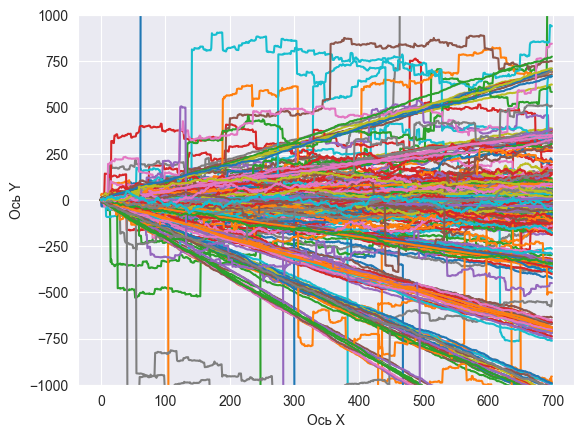

In [448]:
for  i  in range(0,df.shape[0],100):
    plt.plot(df.iloc[i,:700].values)
    # Устанавливаем интервалы по осям x и y
    plt.ylim(-1000, 1000)  # Интервал по оси y от -1 до 1
    
    # Добавляем подписи осей и заголовок
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
    
    # Показываемграфик
plt.show()

Видим, что ряды классифицируются на два типа. Те, которые группируются в пучки и они линейные, и те, у которых часто непрдесказуемый дрифт. Если мы хотим составить три группы и дальше на них что-то катить, наверняка, подразумевается, что было бы плохо включать в группы ряды с такими дрифтами, потому что они могут скакнуть на реальном тесте и испортить статистику. Это одна проблема. Вторая - придётся писать жадный перебор для формирования трёх групп, а он вообще говоря сильно зависит от сида и начального случайного рабиения, и долгий. Далее попробуем избавиться от дрифтующих рядов 

Дифференциируем ряд первой апроксимацией. Линейный ряды, которые собираются в пучки, должны схлопнутся. Дрифтующие - покажут  скачок производной. 

In [449]:
df_copy = df.copy()
x = np.arange(df.shape[1])
for i in range(df.shape[0]):
    df_copy.iloc[i, :] = np.gradient(df.iloc[i, :].values, x)

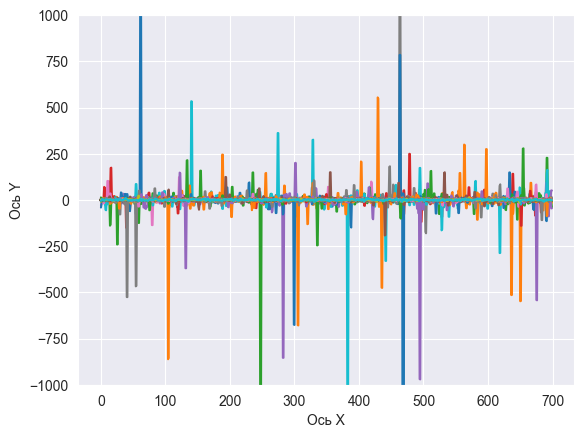

In [450]:
for  i  in range(0,df.shape[0],100):
    plt.plot(df_copy.iloc[i,:700].values)
    # Устанавливаем интервалы по осям x и y
    plt.ylim(-1000, 1000)  # Интервал по оси y от -1 до 1
    
    # Добавляем подписи осей и заголовок
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
    
    # Показываемграфик
plt.show()

In [451]:
max_grad_jump = df_copy.abs().max(axis=1)

In [452]:
max_grad_jump.describe()

count     50000.000000
mean        189.213562
std        6158.398635
min           0.226657
25%           2.888874
50%           4.563078
75%           9.294006
max      972297.364823
dtype: float64

In [453]:
skip_users = [np.abs(max_grad_jump.values) < 5][0] # тут срежем по медиане
df_filtered = df_copy[skip_users]
filtered_index = list(df_filtered.index)
df_good_ts = df.iloc[filtered_index, :]
df_good_ts.reset_index(drop=True, inplace=True)

Text(0, 0.5, 'Ось Y')

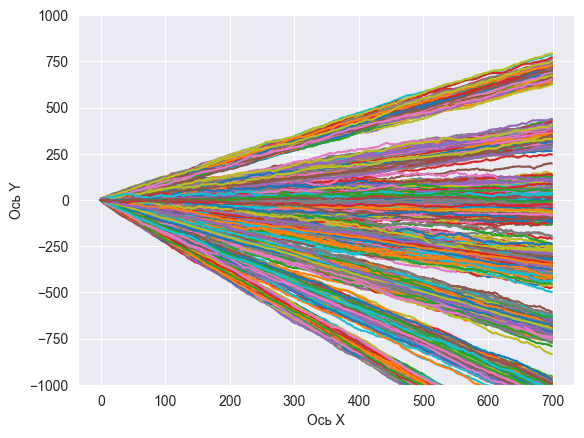

In [454]:
for i in range(0, df_good_ts.shape[0], 10):
    plt.plot(df_good_ts.iloc[i, :700].values)
    # Устанавливаем интервалы по осям x и y
    plt.ylim(-1000, 1000)  # Интервал по оси y от -1 до 1

    # Добавляем подписи осей и заголовок
plt.xlabel('Ось X')
plt.ylabel('Ось Y')


Далее будем бить случайно на бакеты, подразумевая, что в каждый бакет попадёт примерно одинаковое количество рядов из каждого пучка. Далее будем искать бакеты, у которых одинаковые распределения средних и дисперсий по ряду одновременно. Опять таки из-за картины рядов можем точно сказать, что эти кумулятивные метрики внутри себя несут информацию о различии рядов друг от друга.

Проверка на равенство распределений попарная манном-уитни с поправкой на уровень значимости групповой ошибки методом Холта.

In [455]:
df = clean(df)

In [456]:
df["mean"] = df.sum(axis=1)
df["var"] = df.var(axis=1)

In [457]:
df.shape

(26452, 732)

Всего 26 тысяч после очистки, поэтому сплитовать будем на 5 бакетов, чтобы потом просто перебирать по три. 
Продемонстрируем качество разбиения с точки зрения равномерности объёма выборки

In [458]:
#Config
group_num  = 5
test_split_system  = False
# обернём md5 хэш с заданной солью, количеством бакетов
md5_hash_boosted = proxy(hl.md5, "salt" ,group_num, True)

In [459]:
groups = generate_groups(df,group_num,md5_hash_boosted)

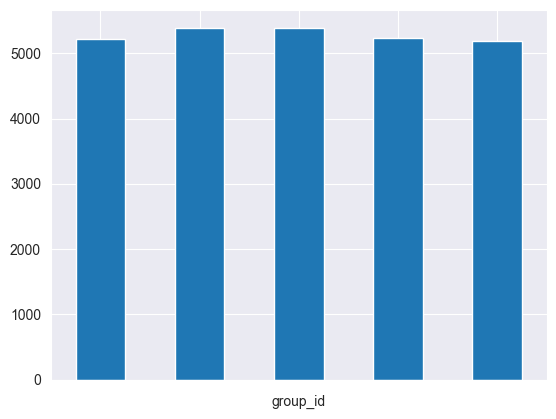

In [460]:
df_md5 = df.groupby("group_id").size()
ax = df_md5.plot(kind='bar', x='id_group_md5', y='count')
ax.set_xticklabels([])
plt.show()

Протестируем систему на состоятельность разбиения.

In [461]:
test_split_system = True

In [462]:
count_good_triples = find_groups(df, group_num, md5_hash_boosted)

Всего мы брали всевозможные пары по три из 5. Общее количество сочетаний 10. 

In [463]:
count_good_triples/10 # рейт успешных  наборов по три

1.0

Теперь найдём конкретные группы

In [464]:
test_split_system = False
md5_hash_boosted = proxy(hl.md5, "test" ,group_num, True)
good_triples = find_groups(df, group_num, md5_hash_boosted)

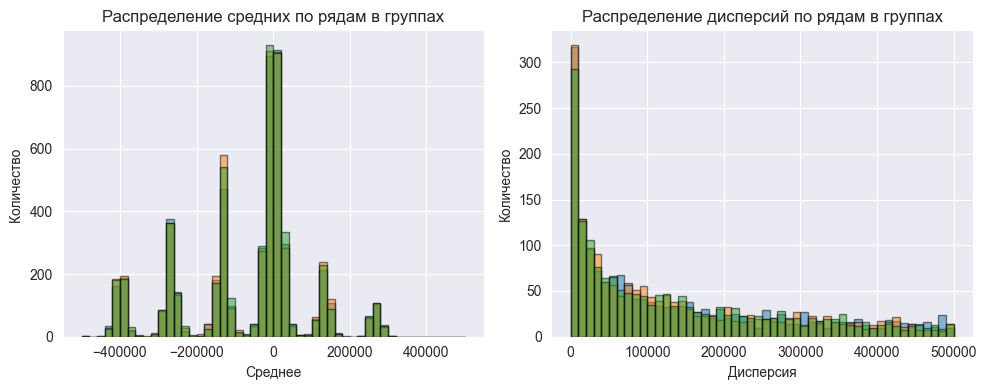

In [465]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # figsize задает размер фигуры
for group in good_triples:
    axes[0].hist(group["mean"], bins=50, alpha=0.5, edgecolor='black', range = (-500_000, 500_000))
    axes[1].hist(group["var"], bins=50, alpha=0.5, edgecolor='black', range = (-10, 500_000))
axes[0].set_title('Распределение средних по рядам в группах')
axes[0].set_xlabel('Среднее')
axes[0].set_ylabel('Количество ')

axes[1].set_title('Распределение дисперсий по рядам в группах')
axes[1].set_xlabel('Дисперсия')
axes[1].set_ylabel('Количество')

# Улучшаем компоновку
plt.tight_layout()

# Показываем графики
plt.show()

### Это распределение нашей кумулятивной метрики среднего в каждой из трёх групп. Теперь посмотрим на подневное среднее и дисперсию

# Visualize groups

In [467]:
index = good_triples[0].columns[:-3] # последние три это среднее, дисперсия, номер группы

In [468]:
index = pd.to_datetime(index)

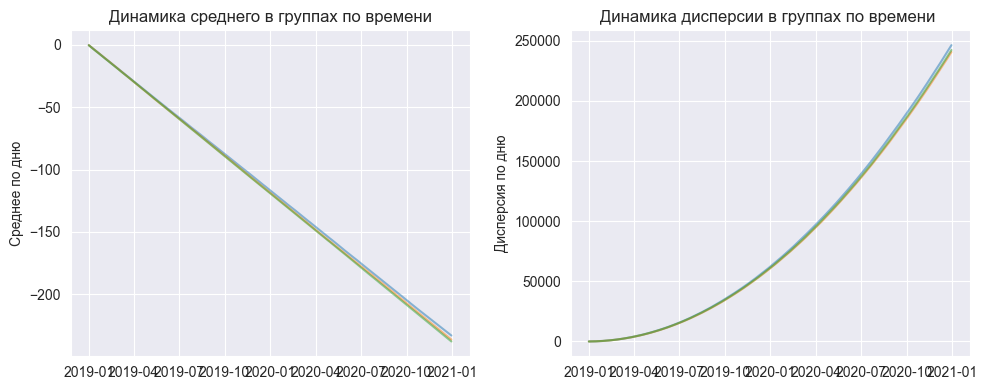

In [469]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # figsize задает размер фигуры
for group in good_triples:
    axes[0].plot(index, group.mean(axis=0).values[:-3], alpha=0.5)
    axes[1].plot(index, group.var(axis=0).values[:-3],  alpha=0.5)
axes[0].set_title('Динамика среднего в группах по времени')
axes[0].set_ylabel('Среднее по дню')

axes[1].set_title('Динамика дисперсии в группах по времени ')
axes[1].set_ylabel('Дисперсия по дню')

# Улучшаем компоновку
plt.tight_layout()

# Показываем графики
plt.show()

#### Случайное разбиение, то есть мы не будем фильтровать ряды, как в начале, и не контролируем распределение дрифтующих рядов по группам

In [470]:
df = pd.read_csv('train_data.csv')

In [471]:
df["mean"] = df.sum(axis=1)
df["var"] = df.var(axis=1)

In [472]:
group_num = 10
test_split_system = False
md5_hash_boosted = proxy(hl.md5, "test" ,group_num, True)
good_triples = find_groups(df, group_num, md5_hash_boosted)

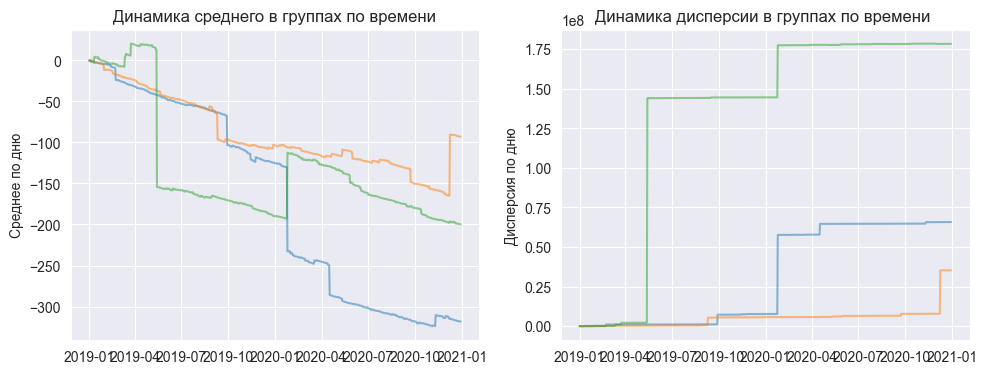

In [473]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # figsize задает размер фигуры
for group in good_triples:
    axes[0].plot(index, group.mean(axis=0).values[:-3], alpha=0.5)
    axes[1].plot(index, group.var(axis=0).values[:-3],  alpha=0.5)
axes[0].set_title('Динамика среднего в группах по времени')
axes[0].set_ylabel('Среднее по дню')

axes[1].set_title('Динамика дисперсии в группах по времени ')
axes[1].set_ylabel('Дисперсия по дню')

# Улучшаем компоновку
plt.tight_layout()

# Показываем графики
plt.show()